In [1]:
##
## UNet 
##
## Взята идея по описанию из https://github.com/pietz/unet-keras
##

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import sklearn.metrics as skm
from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.13.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, save_model, load_model, Input, Model
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D, UpSampling2D, ZeroPadding2D
from keras.layers import Conv2D, Concatenate, Reshape
from keras.layers import Activation, Dropout, Flatten, Dense, Permute
from keras.layers.normalization import BatchNormalization
import keras.optimizers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


In [6]:
keras.__version__

'2.0.6'

In [7]:
#---------------------------------------------------------------------

In [8]:
!ls -la ..
!ls -la ../Data
!ls -la ../Data/training

total 9
drwxrwxrwx 1 boba boba 4096 июл 25 15:24 .
drwxrwxrwx 1 boba boba    0 июл 25 09:21 ..
drwxrwxrwx 1 boba boba 4096 июл 25 09:23 Data
drwxrwxrwx 1 boba boba    0 июл 25 09:22 Data-Arch
drwxrwxrwx 1 boba boba    0 июл 25 09:26 Data-Keras
drwxrwxrwx 1 boba boba  448 июл 25 15:26 .git
-rwxrwxrwx 2 boba boba  130 июл  9 12:02 .gitignore
drwxrwxrwx 1 boba boba    0 июл 25 12:51 Jupyter
drwxrwxrwx 1 boba boba  296 июл 25 15:22 Jupyter-Net
drwxrwxrwx 1 boba boba    0 июл 25 12:32 Temp
drwxrwxrwx 1 boba boba    0 июл 25 09:25 Work
total 16
drwxrwxrwx 1 boba boba 4096 июл 25 09:23 .
drwxrwxrwx 1 boba boba 4096 июл 25 15:24 ..
-rwxrwxrwx 2 boba boba 1060 июн 13 15:55 null_submission_generator.py
-rwxrwxrwx 2 boba boba 1197 июн 13 16:03 random_submission_generator.py
drwxrwxrwx 1 boba boba    0 июл 24 23:10 testing
drwxrwxrwx 1 boba boba    0 июл 25 08:14 training
total 220
drwxrwxrwx 1 boba boba      0 июл 25 08:14 .
drwxrwxrwx 1 boba boba   4096 июл 25 09:23 ..
-rwxrwxrwx 2 boba boba  14

In [9]:
dirData = '../Data'
dirTemp = '../Temp'
dirWork = '../Work'

dirTest  = os.path.join(dirData,'testing','images')
dirTrain = os.path.join(dirData,'training','images')
dirMask  = os.path.join(dirData,'training','truth')

In [10]:
listTrain = os.listdir(dirTrain)
listMask  = os.listdir(dirMask)
listTest  = os.listdir(dirTest)
listTrain = [xx for xx in listTrain if os.path.splitext(xx)[1]=='.tif']
listMask  = [xx for xx in listMask  if os.path.splitext(xx)[1]=='.png']
listTest  = [xx for xx in listTest  if os.path.splitext(xx)[1]=='.tif']
print(len(listTrain),len(listMask),len(listTest))
print(listTrain[:5],'\n',listMask[:5],'\n',listTest[:5])

168 168 162
['i105404.tif', 'i117557.tif', 'i124017.tif', 'i130790.tif', 'i137857.tif'] 
 ['i105404_mask.png', 'i117557_mask.png', 'i124017_mask.png', 'i130790_mask.png', 'i137857_mask.png'] 
 ['i105047.tif', 'i116596.tif', 'i137649.tif', 'i140176.tif', 'i142099.tif']


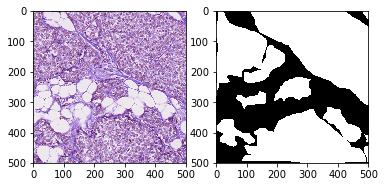

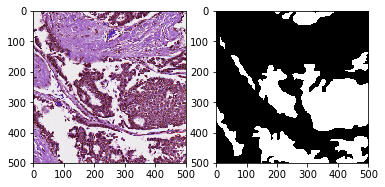

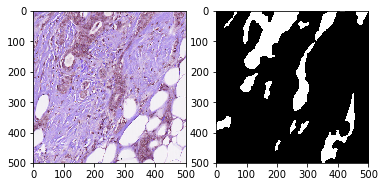

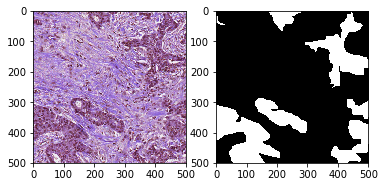

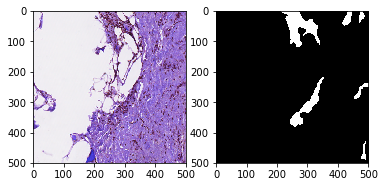

In [97]:
for xx in listTrain[:5] :
    img = cv.imread(os.path.join(dirTrain,xx),-1)
    xxm = os.path.splitext(xx)[0]+"_mask.png"
    msk = cv.imread(os.path.join(dirMask,xxm),-1)
    plt.subplot(121); plt.imshow(img); plt.subplot(122); plt.imshow(msk,'gray'); plt.show()
plt.close()

In [256]:
msk.shape, img.shape, img.min(), img.max(), msk.max(), #img[6:10,6:10], msk[6:10,6:10]

((500, 500), (512, 512, 3), 0.0, 0.96862745098039216, 255)

In [308]:
flagGray = False
Gauss    = False
Median   = False
if flagGray :
    trX, trY, trX0, trY0 = [], [], np.zeros((512,512,1)), np.zeros((512,512,1))
else :
    trX, trY, trX0, trY0 = [], [], np.zeros((512,512,3)), np.zeros((512,512,1))

for xx in listTrain :
    img = cv.imread(os.path.join(dirTrain,xx),-1)
    if 1 and (Gauss or Median): 
        for cc in range(img.shape[2]) : 
            if Gauss  : img[:,:,cc] = cv.GaussianBlur(img[:,:,cc],(3,3),0);
            if Median : img[:,:,cc] = cv.medianBlur  (img[:,:,cc],5);
    xxm = os.path.splitext(xx)[0]+"_mask.png"
    msk = cv.imread(os.path.join(dirMask,xxm),-1)
    #print(img.mean(),msk.mean())
    if flagGray :
        img = cv.cvtColor(img,cv.COLOR_RGB2GRAY);
        trX0[6:506,6:506,0] = img[:,:]/255.0
        trY0[6:506,6:506,0] = msk[:,:]/255.0
    else :
        trX0[6:506,6:506,:] = img[:,:,:]/255.0
        trY0[6:506,6:506,0] = msk[:,:]/255.0
        trY0[trY0>=0.5] = 1.0
    trX.append(trX0.copy())
    trY.append(trY0.copy())
    #print(trX0.mean(),trY0.mean(),trX1[-1].mean(),trY1[-1].mean())

#print([trY[xx].mean() for xx in range(10)])
trX = np.array(trX)
trY = np.array(trY)
    
trX.shape, trX.min(), trX.max(), trY.shape, trY.min(), trY.max()
#[trY[xx].mean() for xx in range(10)]

((168, 512, 512, 3), 0.0, 1.0, (168, 512, 512, 1), 0.0, 1.0)

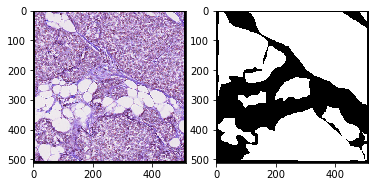

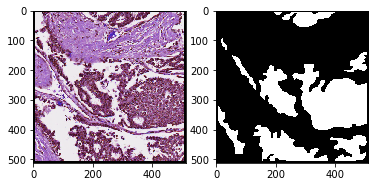

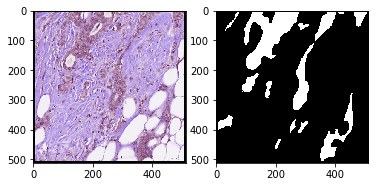

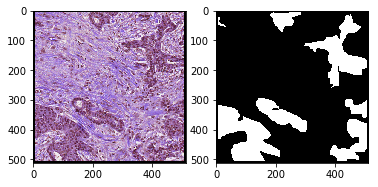

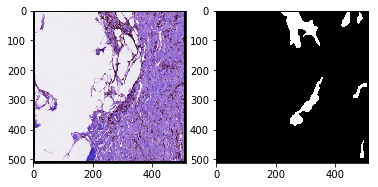

In [309]:
for xx in range(5) :
    img = trX[xx]
    xxm = trY[xx]
    plt.subplot(121); plt.imshow(img); plt.subplot(122); plt.imshow(xxm[:,:,0],'gray'); plt.show()
plt.close()

In [297]:
#
# model UNET
#
#    https://github.com/pietz/unet-keras
#
#

def level_block(m, dim, depth, acti):
    if depth > 0:
        
        x = BatchNormalization(axis=3)(m)
        n = Conv2D(dim, (3, 3), activation=acti, padding='same')(x) #(m)
        n = Conv2D(dim, (3, 3), activation=acti, padding='same')(n)
        n = Dropout(0.25)(n) ## add
        m = MaxPooling2D((2, 2))(n)
        m = level_block(m, 2*dim, depth-1, acti)
        m = UpSampling2D((2, 2))(m)
        m = Conv2D(dim, (2, 2), activation=acti, padding='same')(m)
        m = Dropout(0.25)(m) ## add
        m = Concatenate(axis=3)([n, m])
    m = Conv2D(dim, (3, 3), activation=acti, padding='same')(m)
    return Conv2D(dim, (3, 3), activation=acti, padding='same')(m)

def UNet(img_shape, n_out=2, dim=64, depth=4, acti='relu', flatten=False):
    i = Input(shape=img_shape)
    ## ???? i = ZeroPadding2D((6,6),data_format="channels_last")
    o = level_block(i, dim, depth, acti)
    o = Conv2D(n_out, (1, 1), name='prediction')(o)
    if flatten:
        o = Reshape(n_out, img_shape[0] * img_shape[1])(o)
        o = Permute((2, 1))(o)
    #o = Activation('relu')(o)
    o = Activation('sigmoid')(o)
    return Model(inputs=i, outputs=o)


In [298]:
model10 = UNet((512,512,3),depth=4,n_out=1)
model10.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 512, 512, 3)   0                                            
____________________________________________________________________________________________________
batch_normalization_5 (BatchNorm (None, 512, 512, 3)   12          input_2[0][0]                    
____________________________________________________________________________________________________
conv2d_23 (Conv2D)               (None, 512, 512, 64)  1792        batch_normalization_5[0][0]      
____________________________________________________________________________________________________
conv2d_24 (Conv2D)               (None, 512, 512, 64)  36928       conv2d_23[0][0]                  
___________________________________________________________________________________________

In [299]:
def buildModel (input_shape) :
    model = UNet(input_shape,depth=4,n_out=1)
    
    sgd = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
    model.compile(loss='mean_absolute_error',  #'binary_crossentropy',
                  optimizer=sgd, #sgd, #"adam", #'rmsprop',
                  metrics=['binary_accuracy']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    return(model)

In [310]:
K.clear_session()
model10 = buildModel((trX.shape[1],trX.shape[2],trX.shape[3]))
model10.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 512, 512, 3)   0                                            
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 512, 512, 3)   12          input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 512, 512, 64)  1792        batch_normalization_1[0][0]      
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 512, 512, 64)  36928       conv2d_1[0][0]                   
___________________________________________________________________________________________

In [311]:
#K.clear_session()
#metric = 'acc'
#model10.compile(loss= 'binary_crossentropy', 
                #'mean_squared_error', #'mean_absolute_error',  #'binary_crossentropy','categorical_crossentropy',
#                  optimizer="rmsprop", #sgd, #"adam", #'rmsprop',
#                  metrics=[metrics]) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])


In [312]:
#model10.load_weights('../Data-Keras/Models/model-UNet-weights.h5', by_name=False)

In [313]:
epochs     = 100
verbose    = 2
batch_size = 2
metric     = 'binary_accuracy'

early_stopping = EarlyStopping(monitor='val_loss', patience=7,min_delta=0.0001,verbose=1)
reduce_lr1     = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=3, min_lr=0.000001,verbose=1)
reduce_lr2     = ReduceLROnPlateau(monitor='loss',     factor=0.5,patience=3, min_lr=0.000001,verbose=1)

filepath="../Temp/TrainModel001-G-M/V1-UNET-{val_"+metric+":.4f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
checkpoint = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')


step = 40
low  = 0
high = low+step

print(datetime.datetime.now(),'Training')
#hist1  = model10.fit(trX[low:high],trY[low:high],
hist1  = model10.fit(trX,trY,
                    epochs=epochs, batch_size=batch_size, 
                    validation_split=0.20, 
                    initial_epoch = 0,
                    callbacks=[early_stopping,reduce_lr1,reduce_lr2,checkpoint],
                    verbose=verbose)

print(datetime.datetime.now()) #,pp,'fbeta2s=',fbeta2score,fbeta2pred)

2017-07-25 23:33:34.733731 Training
Train on 134 samples, validate on 34 samples
Epoch 1/100
Epoch 00000: val_binary_accuracy improved from -inf to 0.68344, saving model to ../Temp/TrainModel001-G-M/V1-UNET-0.6834.hdf5
137s - loss: 0.3453 - binary_accuracy: 0.6777 - val_loss: 0.3194 - val_binary_accuracy: 0.6834
Epoch 2/100
Epoch 00001: val_binary_accuracy did not improve
134s - loss: 0.3207 - binary_accuracy: 0.6793 - val_loss: 0.3176 - val_binary_accuracy: 0.6834
Epoch 3/100
Epoch 00002: val_binary_accuracy did not improve
135s - loss: 0.3207 - binary_accuracy: 0.6793 - val_loss: 0.3171 - val_binary_accuracy: 0.6834
Epoch 4/100
Epoch 00003: val_binary_accuracy did not improve
135s - loss: 0.3207 - binary_accuracy: 0.6793 - val_loss: 0.3169 - val_binary_accuracy: 0.6834
Epoch 5/100
Epoch 00004: val_binary_accuracy did not improve
134s - loss: 0.3207 - binary_accuracy: 0.6793 - val_loss: 0.3167 - val_binary_accuracy: 0.6834
Epoch 6/100

Epoch 00005: reducing learning rate to 0.00499999

In [349]:
if 0 : model10 = load_model('../Temp/TrainModel001+G+M/V1-UNET-0.8511.hdf5')
if 1 : model10 = load_model('../Temp/V1-UNET-0.8853.hdf5')

In [350]:
%time trP = model10.predict(trX,batch_size=batch_size)

CPU times: user 35.4 s, sys: 6.54 s, total: 41.9 s
Wall time: 40.6 s


(512, 512, 3) (512, 512, 1) (168, 512, 512, 1) 0.0 1.0


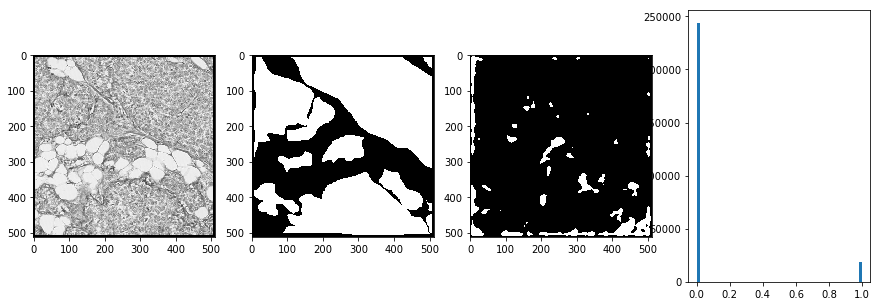

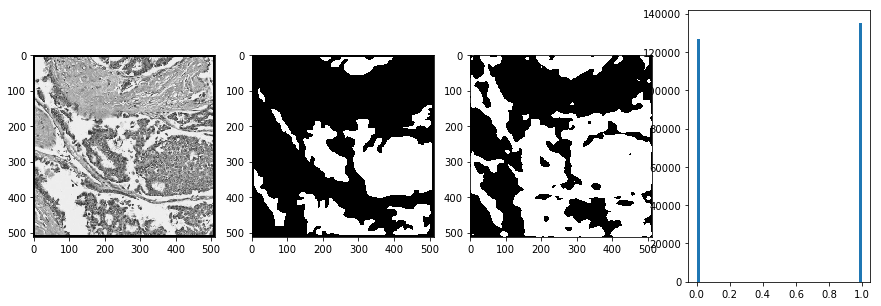

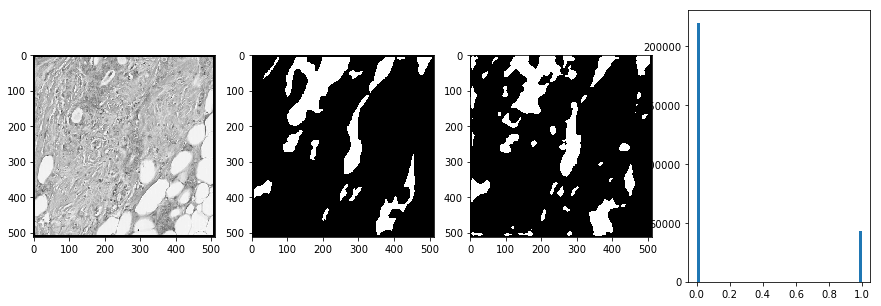

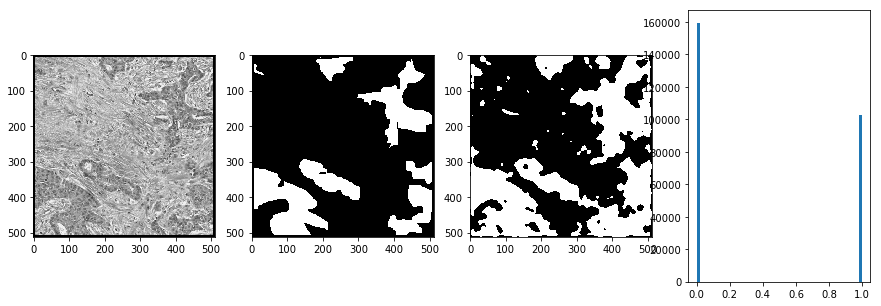

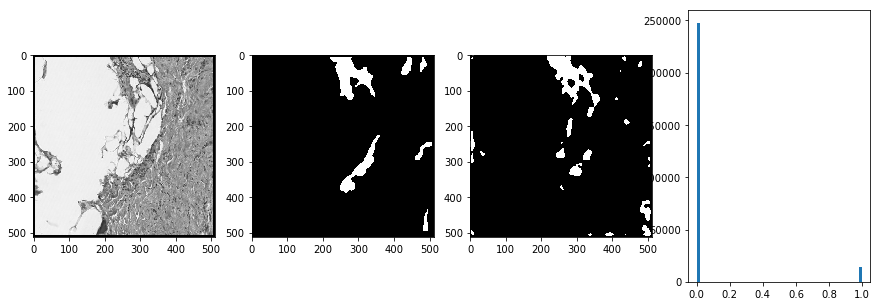

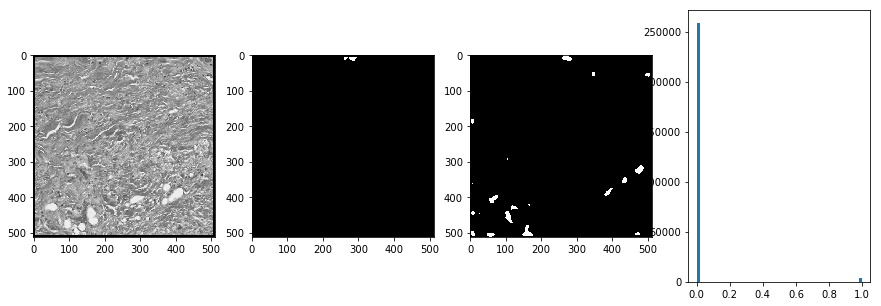

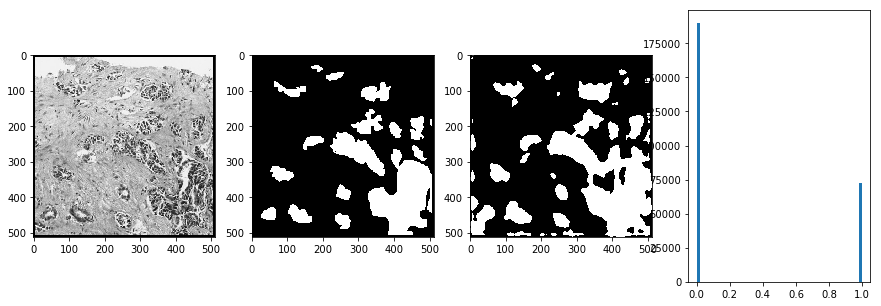

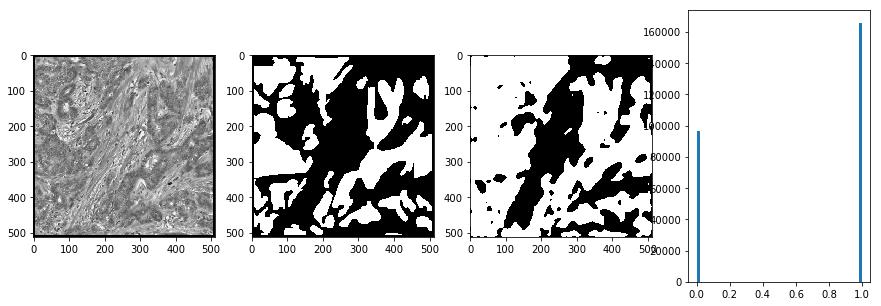

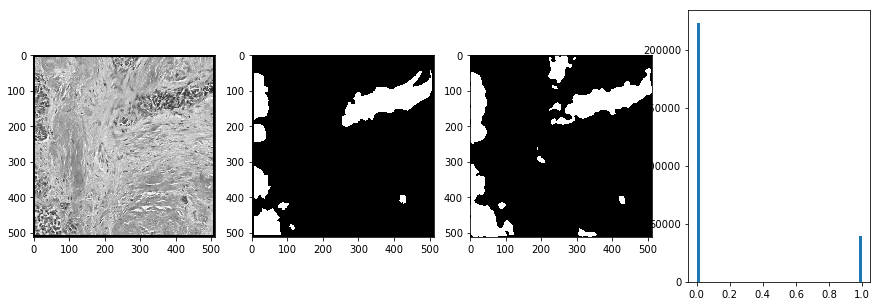

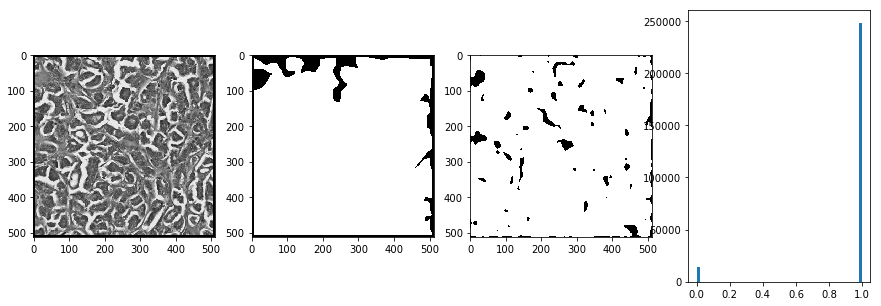

In [410]:
iii = 0
print(trX[0].shape,trY[0].shape,trP.shape,trP.min(),trP.max())
for ii in range(iii,iii+10) :
    plt.figure(figsize=(15,5))
    plt.subplot(141); plt.imshow(trX[ii,:,:,0],'gray'); 
    plt.subplot(142); plt.imshow(trY[ii,:,:,0],'gray'); 
    plt.subplot(143); plt.imshow(trP[ii,:,:,0],'gray'); 
    plt.subplot(144); plt.hist(trP[ii,:,:,0].ravel(),bins=50); 
    plt.show()
plt.close()

In [353]:
trP01 = trP
trP01[trP>0.5] =1.0
trP01[trP<=0.5]=0.0

In [354]:
# Calculate F1-micro

In [361]:
TP = (trY[:,6:506,6:506,0]*trP01[:,6:506,6:506,0]).sum()
TN = ((1.0-trY[:,6:506,6:506,0])*(1.0-trP01[:,6:506,6:506,0])).sum()
FP = ((trY[:,6:506,6:506,0])*(1.0-trP01[:,6:506,6:506,0])).sum()
FN = ((1.0-trY[:,6:506,6:506,0])*(trP01[:,6:506,6:506,0])).sum()

P  = TP/(TP+FP) if (TP+FP)>0.0 else 1.0
R  = TP/(TP+FN) if (TP+FN)>0.0 else 0.0

F1 = 2.0*P*R/(P+R) if (P+R)>0.0 else 0.0

TP,TF,FP,FN,P,R,F1
#P*R,P+R, 2.0*P*R/(P+R)

(11515750.0,
 2572470.0,
 2572470.0,
 4652445.0,
 0.81740276628275255,
 0.71224709993910884,
 0.76121047387801888)

In [362]:
# Calculate DI- dice.mean()

In [366]:
dice, XX = [],[]
for i in range(trP.shape[0]) :
    G = trY  [i,6:506,6:506,0].sum()
    S = trP01[i,6:506,6:506,0].sum()
    X = (trY [i,6:506,6:506,0]*trP01[i,6:506,6:506,0]).sum()
    XX.append(X)
    dice.append((2.0*X/(G+S) if G+S>0 else 1.0))
di = (np.array(dice)).mean()
di,np.array(dice)  #,np.array(XX)

(0.67696073397367551,
 array([ 0.13402725,  0.74137543,  0.76673124,  0.74349419,  0.54935466,
         0.09356725,  0.82090582,  0.78059515,  0.80769403,  0.95822805,
         0.41669842,  0.34912206,  0.66966101,  0.7037494 ,  0.86466   ,
         0.81994419,  0.66060764,  0.7239577 ,  0.82372608,  0.42705361,
         0.17593064,  0.83205196,  0.65058717,  0.50291786,  0.8012776 ,
         0.64680115,  0.85538103,  0.91874461,  0.83172562,  0.84756863,
         0.35497647,  0.94512609,  0.76691414,  0.        ,  0.37590453,
         0.83691595,  0.64705029,  0.60529339,  0.83162129,  0.86671758,
         0.50664729,  0.70824919,  0.66408562,  0.63353523,  0.71382293,
         0.8008884 ,  0.35280143,  0.67901124,  0.73780245,  0.56509729,
         0.82723637,  0.81597503,  0.50094894,  0.39204593,  0.95428937,
         0.80150322,  0.79307134,  0.64200882,  0.90360599,  0.91392971,
         0.16771077,  0.81228089,  0.84875065,  0.59306728,  0.89478836,
         0.42184141,  0.79652

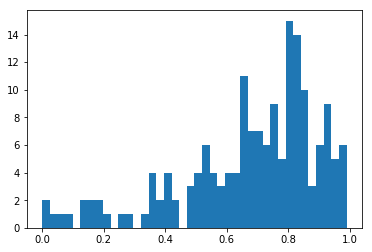

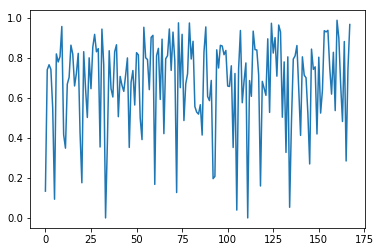

In [364]:
plt.hist(np.array(dice),bins=40); plt.show()
plt.plot(np.array(dice)); plt.show()

In [365]:
1000000*(F1+di)/2.0

719085.60392584722

In [368]:
# Подготовка test решения

In [369]:
if flagGray :
    trO, trO0 = [], np.zeros((512,512,1))
else :
    trO, trO0 = [], np.zeros((512,512,3))

for xx in listTest :
    img = cv.imread(os.path.join(dirTest,xx),-1)
    if 1 and (Gauss or Median): 
        for cc in range(img.shape[2]) : 
            if Gauss  : img[:,:,cc] = cv.GaussianBlur(img[:,:,cc],(3,3),0);
            if Median : img[:,:,cc] = cv.medianBlur  (img[:,:,cc],5);
    #print(img.mean(),msk.mean())
    if flagGray :
        img = cv.cvtColor(img,cv.COLOR_RGB2GRAY);
        trO0[6:506,6:506,0] = img[:,:]/255.0
    else :
        trO0[6:506,6:506,:] = img[:,:,:]/255.0
    trO.append(trO0.copy())
    #print(trX0.mean(),trY0.mean(),trX1[-1].mean(),trY1[-1].mean())

#print([trY[xx].mean() for xx in range(10)])
trO = np.array(trO)
    
trO.shape, trO.min(), trO.max()
#[trY[xx].mean() for xx in range(10)]

((162, 512, 512, 3), 0.0, 1.0)

In [374]:
%time trOP = model10.predict(trO,batch_size=batch_size)

CPU times: user 33.7 s, sys: 6.58 s, total: 40.2 s
Wall time: 39 s


In [375]:
trOP01 = trOP
trOP01[trOP>0.5] =1.0
trOP01[trOP<=0.5]=0.0

In [376]:
# Формирование выходной директории

In [411]:
def convert_to_binary(truth_png_file, truth_txt_file):
    im = Image.open(truth_png_file) #Can be many different formats.
    pix = im.load()
    with open(truth_txt_file, 'w') as out:
        for x in xrange(500):
            for y in xrange(500):
                out.write(str(int(pix[x, y] > 0)))
            out.write('\n')

if not os.path.exists('../Temp/random_submission'):
    os.makedirs('../Temp/random_submission')

# Training
for i in range(len(listTrain)) :
    fn = listTrain[i]
    truth_txt_file = '../Temp/random_submission/' + fn.split('.')[0] + '_mask.txt'
    with open(truth_txt_file, 'w') as out:
        for x in xrange(500):
            for y in xrange(500):
                out.write(str(int(trY[i,y+6, x+6] > 0.0)))
            out.write('\n')
    out.close()
    
# Testing
for i in range(len(listTest)) :
    fn = listTest[i]
    truth_txt_file = '../Temp/random_submission/' + fn.split('.')[0] + '_mask.txt'
    with open(truth_txt_file, 'w') as out:
        for x in xrange(500):
            for y in xrange(500):
                out.write(str(int(trOP01[i,y+6, x+6] > 0.0)))
            out.write('\n')
    out.close()

In [412]:
import shutil

In [413]:
xx=shutil.make_archive('../Work/topcoderkonica','zip','../Temp/random_submission')
xx

'/media/boba/DATA/boba/Working/TopCoder/2017-07-25-Konica-Minolta/Work/topcoderkonica.zip'

In [400]:
!ls ../Temp -la

total 4610508
drwxrwxrwx 1 boba boba      4096 июл 26 10:58 .
drwxrwxrwx 1 boba boba      4096 июл 26 10:11 ..
drwxrwxrwx 1 boba boba         0 июл 25 18:17 .ipynb_checkpoints
drwxrwxrwx 1 boba boba     61440 июл 26 09:14 random_submission
-rwxrwxrwx 1 boba boba   1057596 июл 26 10:58 random_submission.zip
drwxrwxrwx 1 boba boba         0 июл 25 23:35 TrainModel001-G-M
drwxrwxrwx 1 boba boba         0 июл 25 22:21 TrainModel001-G+M
drwxrwxrwx 1 boba boba         0 июл 25 21:48 TrainModel001+G-M
drwxrwxrwx 1 boba boba      4096 июл 25 21:05 TrainModel001+G+M
-rwxrwxrwx 1 boba boba 248418336 июл 25 19:02 V1-UNET-0.8167.hdf5
-rwxrwxrwx 1 boba boba 248418336 июл 25 19:08 V1-UNET-0.8275.hdf5
-rwxrwxrwx 1 boba boba 248418336 июл 25 18:33 V1-UNET-0.8305.hdf5
-rwxrwxrwx 1 boba boba 248418336 июл 25 18:02 V1-UNET-0.8418.hdf5
-rwxrwxrwx 1 boba boba 248418336 июл 25 19:09 V1-UNET-0.8486.hdf5
-rwxrwxrwx 1 boba boba 248418336 июл 25 19:09 V1-UNET-0.8593.hdf5
-rwxrwxrwx 1 boba boba 248418336 июл 25 

In [389]:
!ls ../Work -la
#!ls ../Temp/random_submission

total 80768
drwxrwxrwx 1 boba boba        0 июл 26 09:17 .
drwxrwxrwx 1 boba boba     4096 июл 25 15:24 ..
-rwxrwxrwx 1 boba boba 82700662 июл 26 09:32 topcoderkonica.zip


In [36]:
if False :
    save_model(model10,'../Data-Keras/Models/model-UNet.h5')
    model10.save_weights('../Data-Keras/Models/model-UNet-weights.h5')

In [41]:
rrr=pd.DataFrame(res,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-05-20-05-51-18
